In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df_train = pd.read_csv('/content/drive/My Drive/Rossmann Sales Forecasting/train.csv', 
                       parse_dates=['Date'],
                       date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

df_submit = pd.read_csv('/content/drive/My Drive/Rossmann Sales Forecasting/test.csv', 
                        parse_dates=['Date'],
                        date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

df_store = pd.read_csv('/content/drive/My Drive/Rossmann Sales Forecasting/store.csv')

In [ ]:
#Getting information on train data.
print(f'Shape of train dataset is {df_train.shape}. \n')
print('*'*50 + '\n')

df_train.info()

Shape of train dataset is (1017209, 9). 

**************************************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


Here we can see that train dataset has no nul values right now.

In [ ]:
#Getting information on store data.
print(f'Shape of train dataset is {df_store.shape}. \n')
print('*'*50 + '\n')

df_store.info()

Shape of train dataset is (1115, 10). 

**************************************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


Here there are 5 features with null values. Now we will evaluate them and try to find the reason for the nul  values.

#Promo

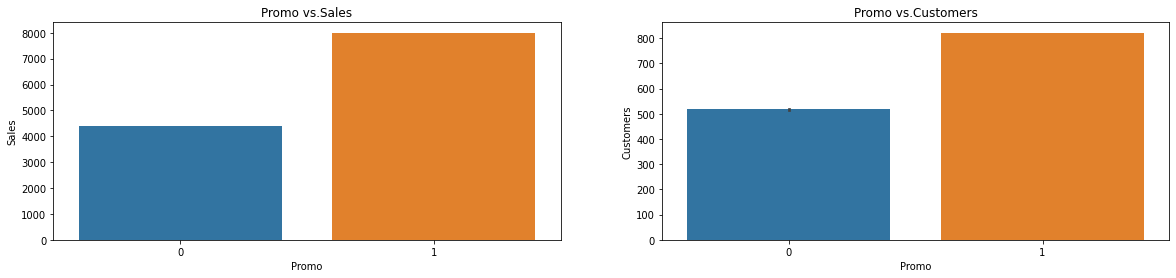

In [ ]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(20,4))

axis1.title.set_text('Promo vs.Sales')
axis2.title.set_text('Promo vs.Customers')
sns.barplot(x='Promo', y='Sales', data=df_train, ax=axis1)
sns.barplot(x='Promo', y='Customers', data=df_train, ax=axis2)

**Obseravtions:**

Here we observe that both Sales and Customers increases by a significant amount during Promotions. This shows that Promotion has a positive effect for a store.

#Date Features

In [ ]:
#Extracting some date features for analysis.
df_train['Year'] = df_train['Date'].dt.year
df_train['Month'] = df_train['Date'].dt.month
df_train['Day'] = df_train['Date'].dt.day
df_train['WeekOfYear'] = df_train['Date'].dt.weekofyear

Text(0.5, 0, 'Week Of Year')

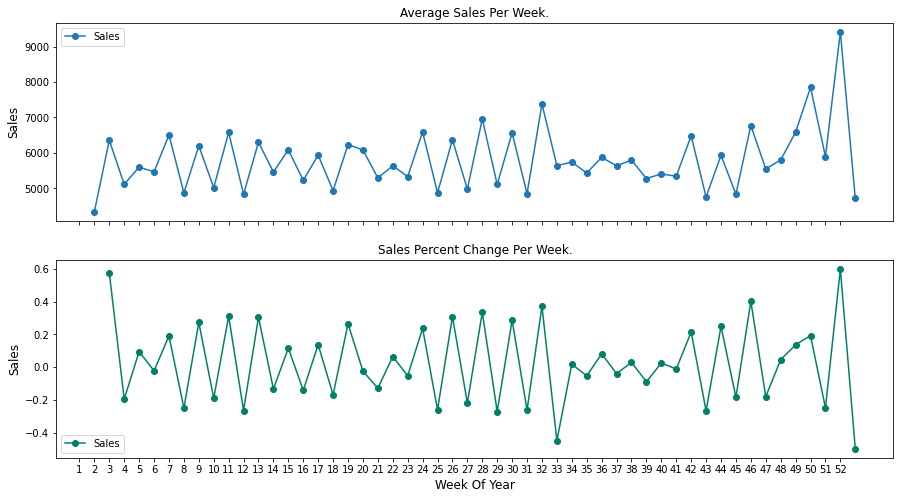

In [ ]:
# group by date and get average sales, and precent change
average_sales    = df_train.groupby('WeekOfYear')["Sales"].mean()
pct_change_sales = df_train.groupby('WeekOfYear')["Sales"].sum().pct_change()

fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

# plot average sales over time(year-month)
ax1 = average_sales.plot(legend=True, ax=axis1, marker='o', title="Average Sales Per Week.")
ax1.set_xticks(range(len(average_sales)))
ax1.set_xticklabels(average_sales.index.tolist())
ax1.set_ylabel('Sales', size=12)

# plot precent change for sales over time(year-month)
ax2 = pct_change_sales.plot(legend=True, ax=axis2, marker='o', colormap="summer", title="Sales Percent Change Per Week.")
plt.ylabel("Sales", size=12)
plt.xlabel('Week Of Year', size=12)

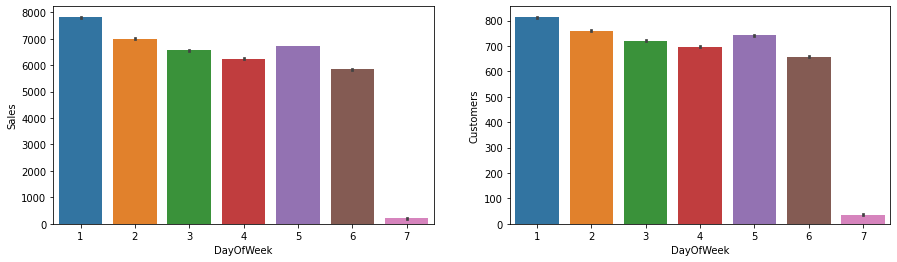

In [ ]:
# DayOfWeek
# In both cases where the store is closed and opened.

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='DayOfWeek', y='Sales', data=df_train, order=[1,2,3,4,5,6,7], ax=axis1)
sns.barplot(x='DayOfWeek', y='Customers', data=df_train, order=[1,2,3,4,5,6,7], ax=axis2)

**Observations:**
Here we observe that Sales and Customers are both very less on Sundays as most of the stores are closed on Sunday.

Also, Sales on Monday is highest in whole week. This might be due to the fact that stores are closed on Sundays.

It is also interesting to note that Christmas and New Year lead to increase in sales. As Rossmann Stores sells health and beauty products, it may be guessed that during Christmas and New Year people buy beauty products as they go out to celebrate and, this might the cause of sudden increase in sales.


#Open Column.

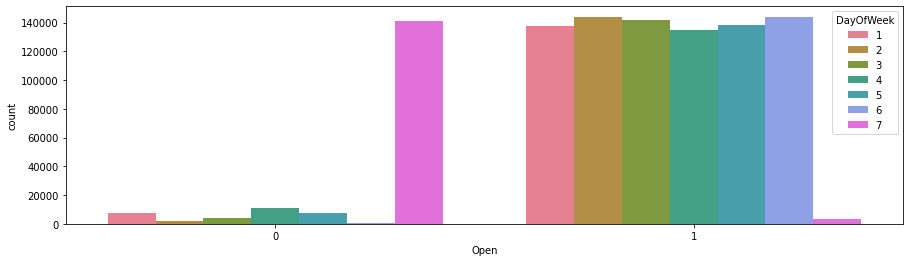

In [ ]:
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.countplot(x='Open',hue='DayOfWeek', data=df_train,palette="husl", ax=axis1)

**Observations:**

This clearly shows that most of the stores remain closed during Sundays. Some stores were closed in weekdays too, this might be due to State Holidays as stores are generally closed during State Holidays and opened during School Holidays.

#State and Schoool Holiday.

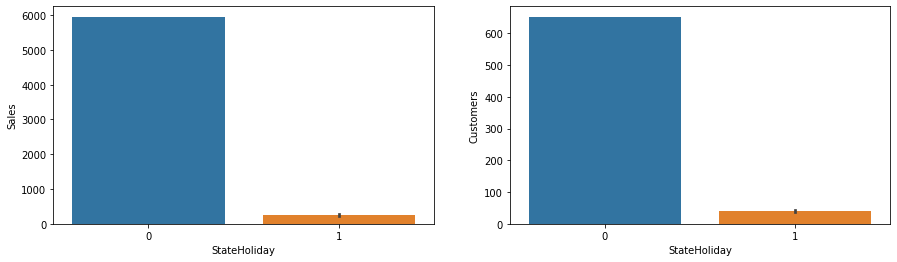

In [ ]:
#State Holiday.
df_train["StateHoliday"] = df_train["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='StateHoliday', y='Sales', data=df_train, ax=axis1)
sns.barplot(x='StateHoliday', y='Customers', data=df_train, ax=axis2)

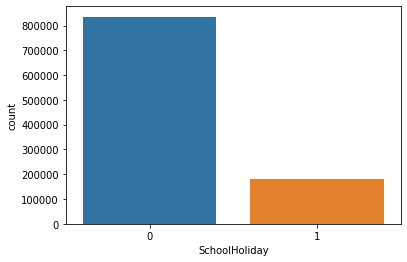

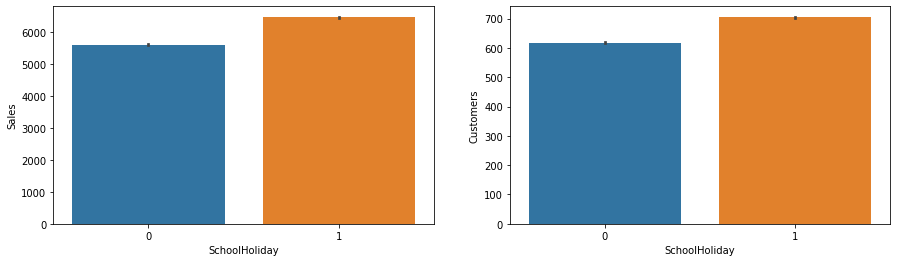

In [ ]:
#School Holiday.
sns.countplot(x='SchoolHoliday', data=df_train)

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='SchoolHoliday', y='Sales', data=df_train, ax=axis1)
sns.barplot(x='SchoolHoliday', y='Customers', data=df_train, ax=axis2)

**Observations:**

We can observe that most of the stores remain closed during State and School Holidays. But it is interesting to note that the number of stores opened during School Holidays were more than that were opened during State Holidays. 

Another important thing to note is that the stores which were opened during School holidays had more sales than normal.

In [ ]:
#Joining store data and train data.
df = pd.merge(df_train, df_store, how='left', on='Store')

#Store Types.

In [ ]:
df.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,551627.0,5738.179710,3964.028134,0.0,3508.0,5618.0,7860.00,41551.0
b,15830.0,10058.837334,5280.525506,0.0,6227.0,9025.5,13082.75,38722.0
c,136840.0,5723.629246,3721.700886,0.0,3789.0,5766.0,7849.00,31448.0
d,312912.0,5641.819243,3473.393781,0.0,3986.0,5826.0,7691.00,38037.0


In [ ]:
df.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541434,3165334859
b,31465621,159231395
c,92129705,783221426
d,156904995,1765392943


**Observations:**

Stores of type B has the highest average of Sales among others but, we have much less data for StoreType B.

But as we see further stores of type A has higher amount of total Customers and Sales. StoreType D goes on the second place in both Sales and Customers.

#Checking duration of Promo.

In [ ]:
df_store_1 = df.loc[df['Store']==1]

In [ ]:
df_store_1.sort_values('Date', inplace=True)
df_store_1.head(50)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1016095,1,2,2013-01-01,0,0,0,0,1,1,2013,1,1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1014980,1,3,2013-01-02,5530,668,1,0,0,1,2013,1,2,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1013865,1,4,2013-01-03,4327,578,1,0,0,1,2013,1,3,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1012750,1,5,2013-01-04,4486,619,1,0,0,1,2013,1,4,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1011635,1,6,2013-01-05,4997,635,1,0,0,1,2013,1,5,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1010520,1,7,2013-01-06,0,0,0,0,0,1,2013,1,6,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1009405,1,1,2013-01-07,7176,785,1,1,0,1,2013,1,7,2,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1008290,1,2,2013-01-08,5580,654,1,1,0,1,2013,1,8,2,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1007175,1,3,2013-01-09,5471,626,1,1,0,1,2013,1,9,2,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1006060,1,4,2013-01-10,4892,615,1,1,0,1,2013,1,10,2,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [ ]:
df_store_2 = df.loc[df['Store']==2]

df_store_2.sort_values('Date', inplace=True)
df_store_2.head(55)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1016096,2,2,2013-01-01,0,0,0,0,1,1,2013,1,1,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
1014981,2,3,2013-01-02,4422,650,1,0,0,1,2013,1,2,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
1013866,2,4,2013-01-03,4159,555,1,0,0,1,2013,1,3,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
1012751,2,5,2013-01-04,4484,574,1,0,0,1,2013,1,4,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
1011636,2,6,2013-01-05,2342,324,1,0,0,0,2013,1,5,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
1010521,2,7,2013-01-06,0,0,0,0,0,0,2013,1,6,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
1009406,2,1,2013-01-07,6775,763,1,1,0,0,2013,1,7,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
1008291,2,2,2013-01-08,6318,685,1,1,0,0,2013,1,8,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
1007176,2,3,2013-01-09,6763,785,1,1,0,0,2013,1,9,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
1006061,2,4,2013-01-10,5618,637,1,1,0,0,2013,1,10,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [ ]:
df_store_2.loc[df_store_2['Month']>3].head(60)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
915746,2,1,2013-04-01,0,0,0,0,1,1,2013,4,1,14,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
914631,2,2,2013-04-02,3643,507,1,0,0,1,2013,4,2,14,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
913516,2,3,2013-04-03,4250,600,1,0,0,1,2013,4,3,14,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
912401,2,4,2013-04-04,4114,542,1,0,0,1,2013,4,4,14,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
911286,2,5,2013-04-05,3872,470,1,0,0,1,2013,4,5,14,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
910171,2,6,2013-04-06,2461,315,1,0,0,0,2013,4,6,14,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
909056,2,7,2013-04-07,0,0,0,0,0,0,2013,4,7,14,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
907941,2,1,2013-04-08,6696,732,1,1,0,0,2013,4,8,15,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
906826,2,2,2013-04-09,6574,667,1,1,0,0,2013,4,9,15,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
905711,2,3,2013-04-10,6520,780,1,1,0,0,2013,4,10,15,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [ ]:
df_store_1115 = df.loc[df['Store']==1115]

df_store_1115.sort_values('Date', inplace=True)
df_store_1115.head(55)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1017208,1115,2,2013-01-01,0,0,0,0,1,1,2013,1,1,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1016094,1115,3,2013-01-02,3697,305,1,0,0,1,2013,1,2,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1014979,1115,4,2013-01-03,4297,300,1,0,0,1,2013,1,3,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1013864,1115,5,2013-01-04,4540,326,1,0,0,1,2013,1,4,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1012749,1115,6,2013-01-05,4771,339,1,0,0,1,2013,1,5,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1011634,1115,7,2013-01-06,0,0,0,0,0,1,2013,1,6,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1010519,1115,1,2013-01-07,6905,471,1,1,0,1,2013,1,7,2,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1009404,1115,2,2013-01-08,5243,341,1,1,0,1,2013,1,8,2,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1008289,1115,3,2013-01-09,4649,324,1,1,0,1,2013,1,9,2,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1007174,1115,4,2013-01-10,5007,339,1,1,0,1,2013,1,10,2,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


**Observations:**

Here we can see that store has a promo period of 5 days and whenever there's a promo, it happens for two times in a month. Thus, as we have seen in 'Promo' analysis that promo increases sales, we can expect that the month with Promo equal to 1, will have 10 days where sales will be more than regular times.

#Checking seasonalities using Fourier transform features.

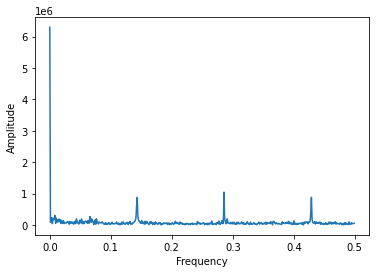

In [ ]:
#Store Type 'A'.
df_store_11_sales = df.loc[df['Store']==11]['Sales']

# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
Y    = np.fft.fft(df_store_11_sales.values)
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(len(Y), 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

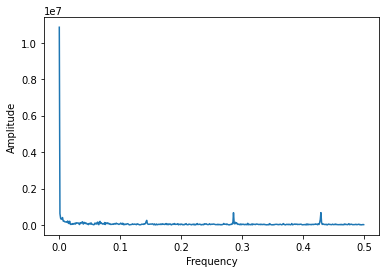

In [ ]:
#Store Type 'B'.
df_store_259_sales = df.loc[df['Store']==259]['Sales']

# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
Y = np.fft.fft(df_store_259_sales.values)
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(len(Y), 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

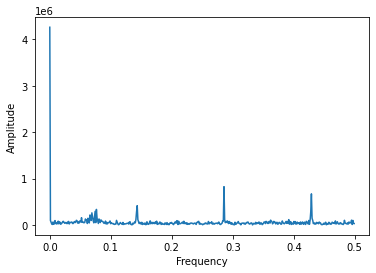

In [ ]:
#Store Type 'C'.
df_store_21_sales = df.loc[df['Store']==21]['Sales']

# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
Y    = np.fft.fft(df_store_21_sales.values)
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(len(Y), 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

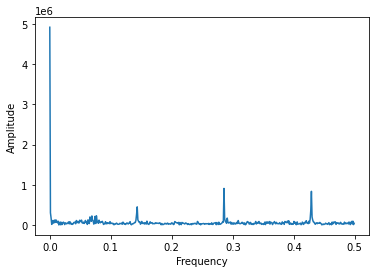

In [ ]:
#Store Type 'D'.
df_store_1115_sales = df.loc[df['Store']==1115]['Sales']

# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
Y    = np.fft.fft(df_store_1115_sales.values)
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(len(Y), 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

**Observations:**

In the above graphs we can see that there are some spikes at particular frequencies. This indicates that there is a seasonality component in the store sales data.

Thus we can use these Fourier features to indicate the seasonality in the data.

#Competition Open Since Year/Month.

In [ ]:
percent_year = 100 * (len(df_store.loc[pd.isnull(df_store['CompetitionOpenSinceYear'])])) / len(df_store)
percent_month = 100 * (len(df_store.loc[pd.isnull(df_store['CompetitionOpenSinceMonth'])])) / len(df_store)

print(f'The percent of missing values in Competition Open Since Year feature is {percent_year}.')
print(f'The percent of missing values in Competition Open Since Month feature is {percent_month}.')

The percent of missing values in Competition Open Since Year feature is 31.748878923766817.
The percent of missing values in Competition Open Since Month feature is 31.748878923766817.


In [ ]:
df_store.loc[pd.isnull(df_store['CompetitionOpenSinceYear'])]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


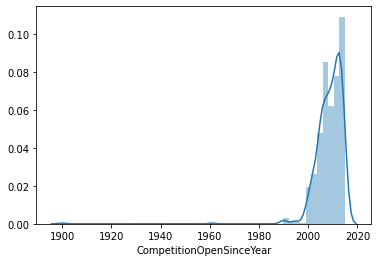

In [ ]:
sns.distplot(df_store['CompetitionOpenSinceYear'])

In [ ]:
year_median = df_store['CompetitionOpenSinceYear'].median()
print(f'Most of stores have their competition opened in the year {year_median}.')

Most of stores have their competition opened in the year 2010.0.


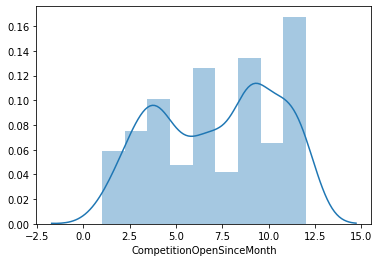

In [ ]:
sns.distplot(df_store['CompetitionOpenSinceMonth'])

In [ ]:
month_median = df_store['CompetitionOpenSinceMonth'].median()
print(f'Most of stores have their competition opened in the month {month_median}.')

Most of stores have their competition opened in the month 8.0.


#CompetitionDistance.

In [ ]:
df_store.loc[pd.isnull(df_store['CompetitionDistance'])]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


Text(0.5, 0, 'Competition Distance in meters')

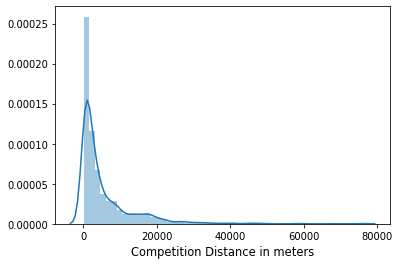

In [ ]:
#Plotting distribution of Competition Distance.
sns.distplot(df_store['CompetitionDistance'])
plt.xlabel('Competition Distance in meters',fontsize=11.5)

In this figure we can see that most of the stores have their competition within 5km range.



**Observations:**

It is interesting to note that missing values in CompetitionOpenYear/Month doesn't indicate that there's no competiotion near the store as the value of  CompetitionDistance is not null where the CompetitionOpenYear/Month is null.

Thus they are not dependent on each other and absence of one value doesn't indicate that other will be absent.

#Promo2SinceWeek

In [ ]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,31,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,31,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
df_store.loc[df_store['Promo2']==0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


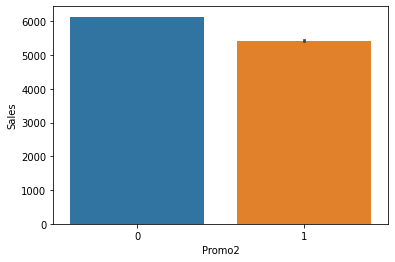

In [ ]:
sns.barplot(df['Promo2'], y=df['Sales'])

In [ ]:
no_promo2_sales = df.loc[df['Promo2']==0]['Sales'].sum()
promo2_sales = df.loc[df['Promo2']==1]['Sales'].sum()

print(f'The difference in sales of stores with no Promo2 and sales with Promo2 is {no_promo2_sales - promo2_sales}.')

The difference in sales of stores with no Promo2 and sales with Promo2 is 349904633.


**Observaation:**

Here we observe that stores which didn't participate in Promo2, have NaN values in features Promo2SinceWeek/Year and PromoInterval. This simply means that no Promo2 implies that all these features have no value. Thus to indicate that we can replace NaN values in these 3 features with -1. -1 will represent that the particular store didn't participate in Promo2.

It is interesting to note that the total sales of stores that didn't participate in Promo2 is greater than the total of sales of stores which participated in the Promo2. And the difference between the two is pretty big(almost 350 million units). 

#**Conclusions of EDA**:


*   The most selling and crowded store type is A.

*   Sales is highly correlated to number of Customers.

*   For all stores, Promotion leads to increase in Sales and Customers both. 

*   The stores which are opened during School Holiday have more sales than normal days.

*   Whenever a Store participate in a Promotion, it is done for 5 days and twice a month for every store.

*   More stores are opened during School holidays than State holidays.

*   Sales are increased during Chirstmas week, this might be due to the fact that people buy more beauty products during a Christmas celebration.

*   Absence of values in features CompetitionOpenSinceYear/Month doesn't indicate the absence of competition as CompetitionDistance values are not null where the other two values are null.

*  After analysing sales using Fourier decomposition, I found that there's a seasonality component in the Sales data.





